In [1]:
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import pytensor
import pytensor.tensor as pt
import pymc.sampling_jax
import numpyro
import blackjax
import jax
from sklearn.preprocessing import StandardScaler
import random

import arviz as az


settings = {'figure.figsize':(14,4),
            'figure.dpi':144,
            'figure.facecolor':'w',
            'axes.spines.top':False,
            'axes.spines.bottom':False,
            'axes.spines.left':False,
            'axes.spines.right':False,
            'axes.grid':True,
            'grid.linestyle':'--',
            'grid.linewidth':0.5, 
            'figure.constrained_layout.use':True}
plt.rcParams.update(settings)


# SEED = sum(map(ord, 'Forcasting in PyMC'))
# rng = np.random.default_rng(SEED)

In [2]:
def plot_results(idata, test_data=None, oos_name='Test'):
    groups = ['posterior_predictive', 'predictions', 'observed_data']
    colors = ['tab:blue', 'tab:orange', 'tab:red']
    labels = ['Training', oos_name, 'Data']
    fig, ax = plt.subplots()
    
    time_dim_name = list(idata.observed_data.dims.keys())[0]
    x_train = idata.observed_data.coords[time_dim_name]
    
    H = list(idata.predictions.dims.values())[-1]
    x_test = np.arange(x_train[-1], x_train[-1] + H)
    
    x_values = [x_train, x_test, x_train]
    
    for group, color, label, x_val in zip(groups, colors, labels, x_values):
        data = getattr(idata, group).y_hat
        
        if group == 'observed_data':
            ax.plot(x_val, data, c=color, label=label)
            continue
            
        hdi = az.hdi(data).y_hat
        ax.plot(x_val, data.mean(dim=['chain', 'draw']), label=label)
        ax.fill_between(x_val, *hdi.values.T, color=color, alpha=0.25)
    if test_data is not None:
        ax.plot(x_test, test_data, color='tab:red')
    ax.legend()
    plt.show()

### 
Is it necessary to difference time serier data or make it stationary in some way?
###

### Create time series data including a trend and one clearly non-stationary feature

$
Y_t = \alpha + \beta\_trend \cdot t
$

In [3]:
true_alpha = 1.0
true_beta_trend = 0.5
true_beta_regressor = 2.5
true_sigma = 3.5
T = 100
noise = np.random.normal(loc=0.0, scale=true_sigma, size=100)
t = np.arange(T)

### Create data
data = true_alpha + true_beta_trend * t + true_beta_regressor * t  + noise
date = pd.date_range("1998-01-01", periods=100, freq="QS")

df = pd.DataFrame({"data": data}, index=date)
df['date'] = df.index
df['noise'] = noise
df

,data,date,noise
1998-01-01,-3.946591,1998-01-01,-4.946591
1998-04-01,10.056263,1998-04-01,6.056263
1998-07-01,10.374810,1998-07-01,3.374810
1998-10-01,14.996632,1998-10-01,4.996632
1999-01-01,20.330611,1999-01-01,7.330611
...,...,...,...
2021-10-01,285.862021,2021-10-01,-0.137979
2022-01-01,288.100096,2022-01-01,-0.899904
2022-04-01,290.264483,2022-04-01,-1.735517
2022-07-01,290.687937,2022-07-01,-4.312063


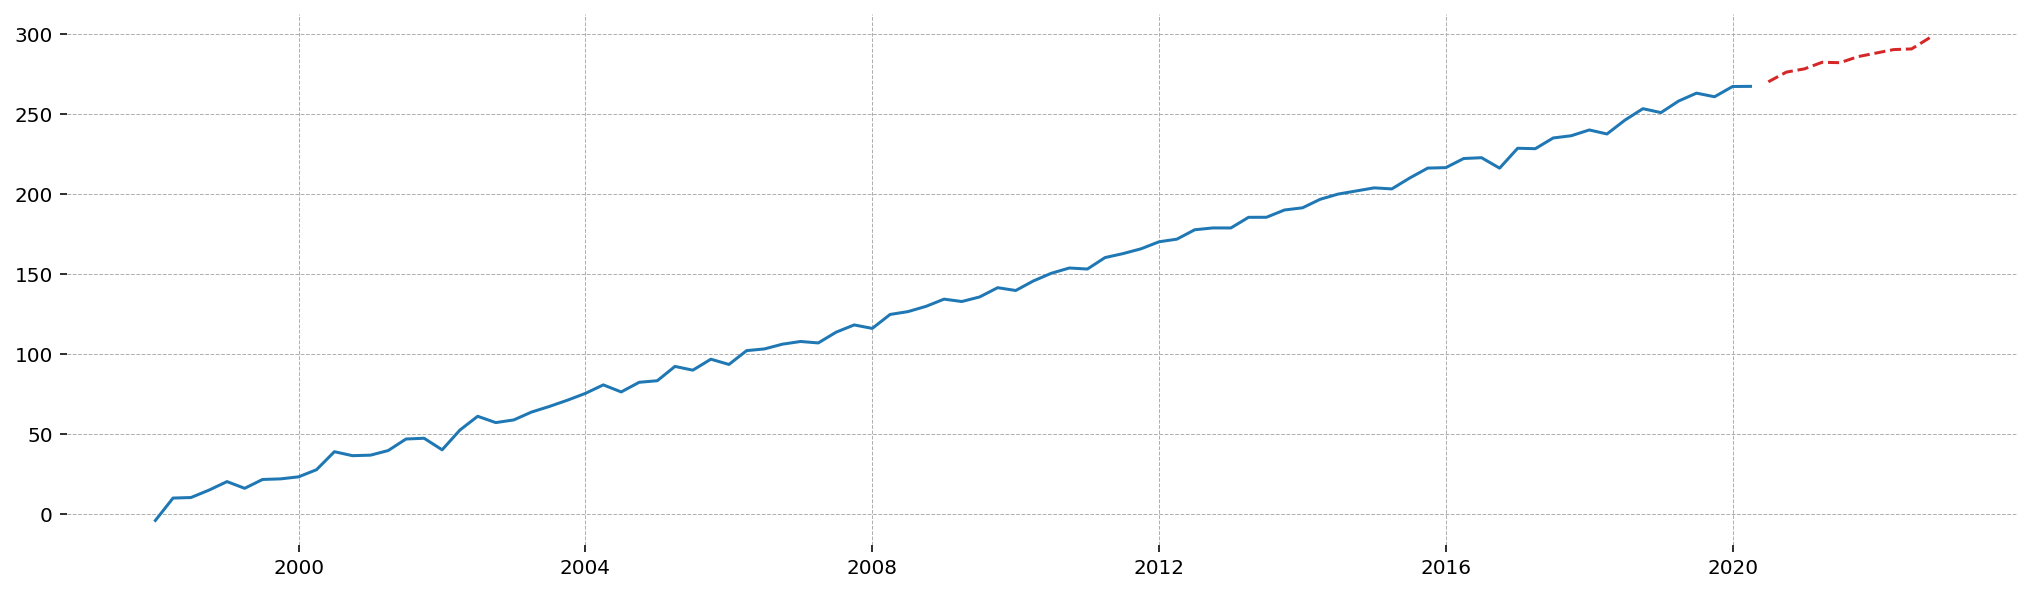

In [4]:
train_data = df[:90]
test_data = df[-10:]

plt.plot(train_data['data'], color='tab:blue')
plt.plot(test_data['data'], ls='--', color='tab:red')

Standardize data

In [5]:
# standardize
t = (df['date'] - pd.Timestamp("1900-01-01")).dt.days.to_numpy()

t_min = np.min(t)
t_max = np.max(t)
df["date"] = (t - t_min) / (t_max - t_min)

y = df["data"].to_numpy()
y_max = np.max(y)
df['data'] = y / y_max


df1 = pd.DataFrame({''})

data_train = df[:90]
data_test = df[-10:]
data_train

untransform = {
  "ymax": y_max,
  "t_min": t_min,
  "t_max": t_max
}

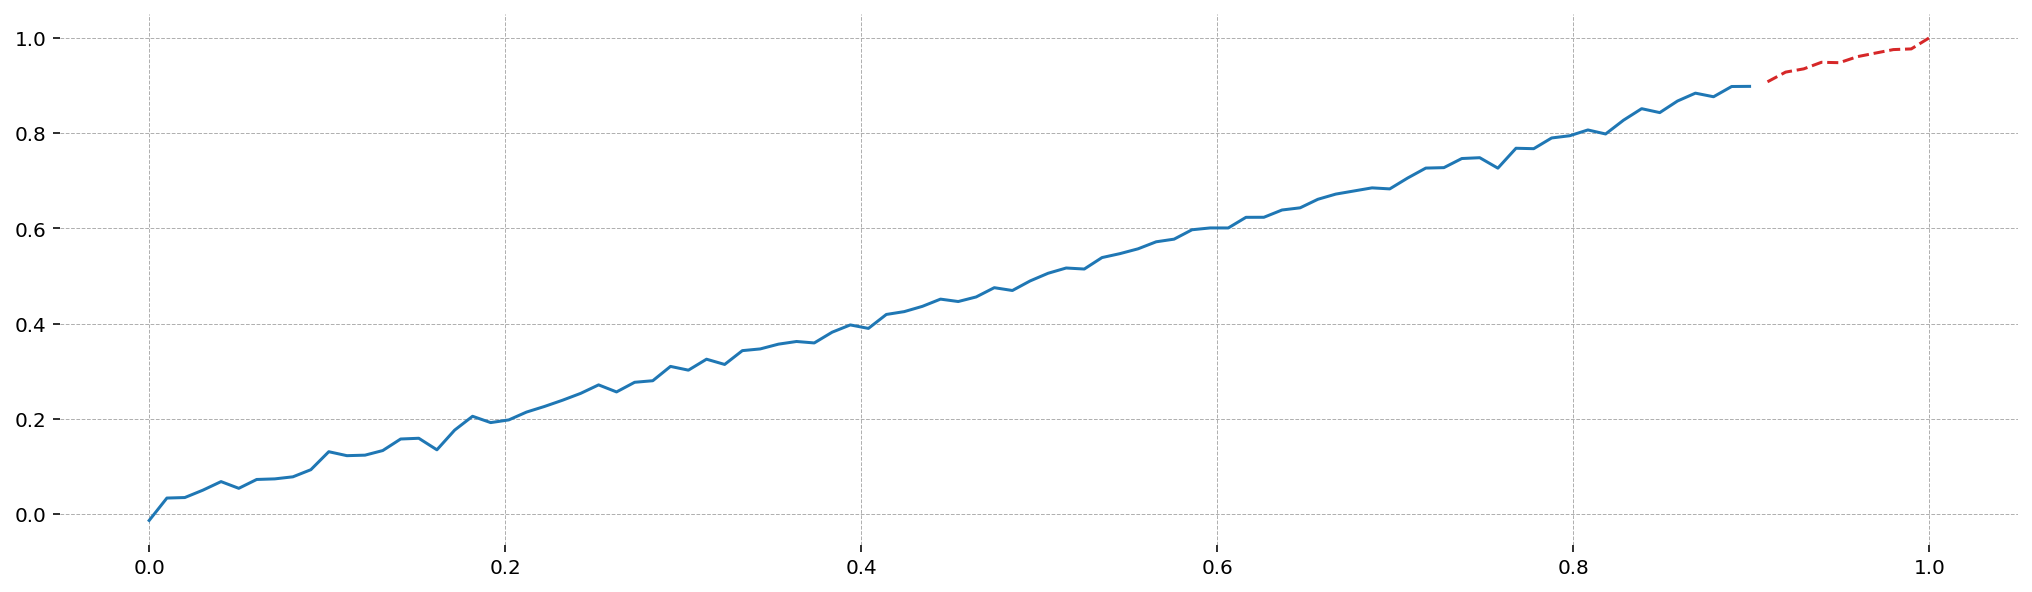

In [6]:
plt.plot(data_train['date'], data_train['data'], color='tab:blue')
plt.plot(data_test['date'], data_test['data'], ls='--', color='tab:red')

/home/jpp/miniconda3/envs/pymc_env/lib/python3.12/site-packages/pymc/data.py:304: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
Sampling: [alpha, beta_trend, sigma, true_beta_regressor, y_hat]
/tmp/ipykernel_14988/3193933918.py:33: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(linear_prior, group="prior", num_samples=90)["mu"] * np.max(data_train['data']),


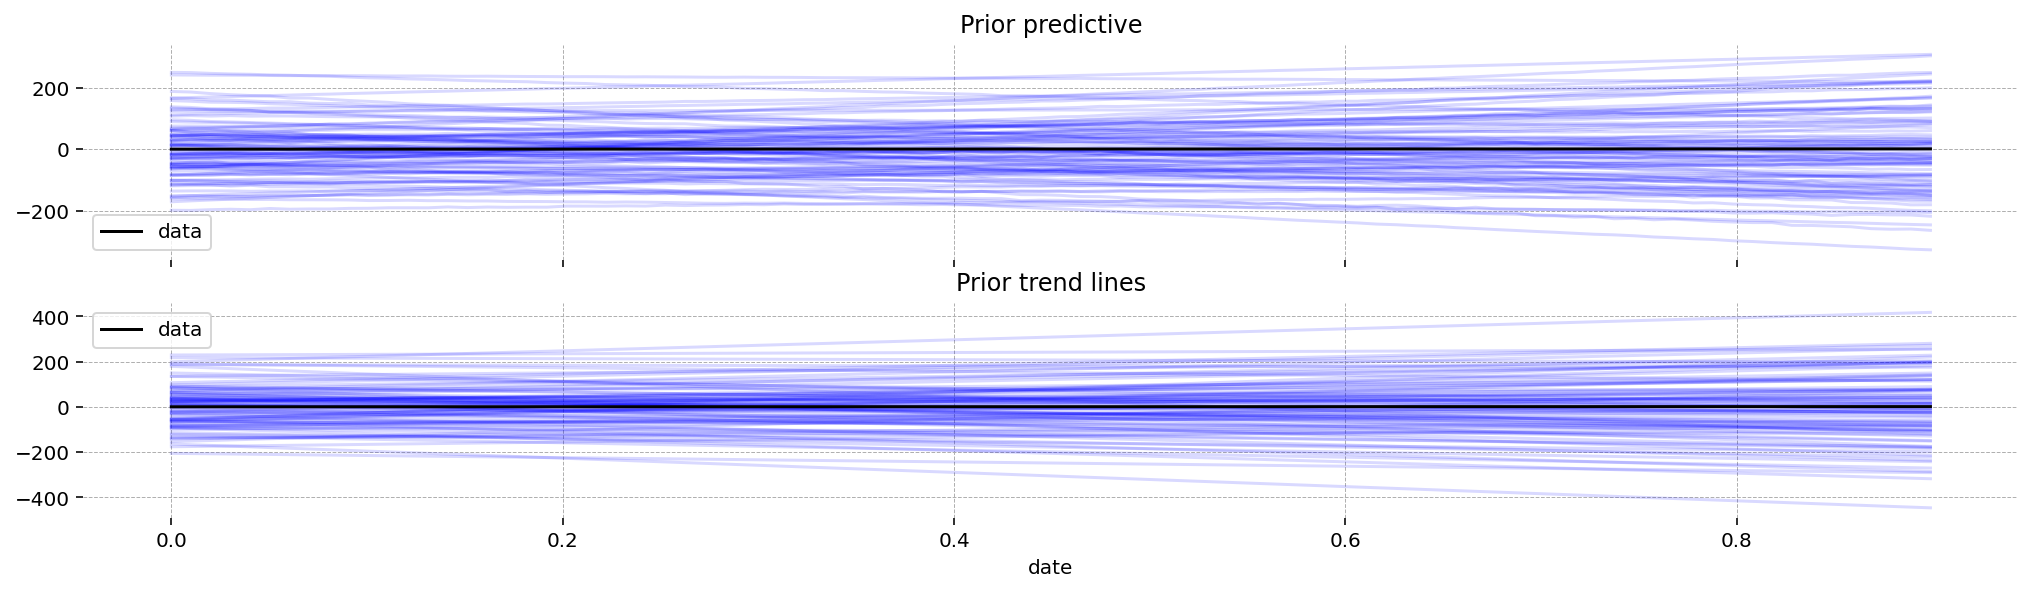

In [7]:
with pm.Model() as det_trend:

    # time
    t_pt = pm.MutableData('t', data_train['date'][0:90])
    
    # model
    alpha = pm.Normal('alpha', mu = 0, sigma=.5)
    beta_trend = pm.Normal('beta_trend', mu = 0, sigma=.5)
    true_beta_regressor = pm.Normal('true_beta_regressor', mu=0, sigma=10)
    sigma = pm.HalfNormal('sigma', sigma=1.)
    
    mu = pm.Deterministic('mu', alpha + beta_trend * t_pt + true_beta_regressor * t_pt)
    
    y_hat = pm.Normal('y_hat', mu=mu, sigma=sigma, observed=data_train['data'], shape=t_pt.shape)
    
    linear_prior = pm.sample_prior_predictive()

############################################################################################################

fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)
ax[0].plot(
    data_train['date'],
    az.extract(linear_prior, group="prior_predictive", num_samples=90)["y_hat"],
    color="blue",
    alpha=0.15,
)
data_train.plot(x='date', y="data", color="k", ax=ax[0])
ax[0].set_title("Prior predictive")


ax[1].plot(
    data_train['date'],
    az.extract_dataset(linear_prior, group="prior", num_samples=90)["mu"] * np.max(data_train['data']),
    color="blue",
    alpha=0.15,
)
data_train.plot(x="date", y="data", color="k", ax=ax[1])
ax[1].set_title("Prior trend lines");


In [8]:
with det_trend:
    linear_trace = pm.sample(return_inferencedata=True)
    linear_prior = pm.sample_posterior_predictive(trace=linear_trace)

############################################################################################################

fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)
ax[0].plot(
    data_train["date"],
    az.extract_dataset(linear_prior, group="posterior_predictive", num_samples=90)["y_hat"],
    color="blue",
    alpha=0.01,
)
data_train.plot(x="date", y="data", color="k", ax=ax[0])
ax[0].set_title("Posterior predictive")
ax[1].plot(
    data_train["date"],
    az.extract_dataset(linear_trace, group="posterior", num_samples=90)["mu"] * np.max(data_train['data']),
    color="blue",
    alpha=0.01,
)
data_train.plot(x="date", y="data", color="k", ax=ax[1])
ax[1].set_title("Posterior trend lines");


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_trend, true_beta_regressor, sigma]


Output()

In [ ]:
az.summary(linear_trace, round_to=2, var_names=["alpha", "beta_trend", "true_beta_regressor", "sigma"])

In [ ]:
az.plot_trace(linear_trace, var_names=["alpha", "beta_trend", "true_beta_regressor", "sigma"], compact=False);

In [ ]:
untransform
az.summary(linear_trace, round_to=2, var_names=["beta_trend"])["mean"] * y_max/100
